# Data Analysis





## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud


In [ ]:
! unzip creditcardfraud.zip

In [4]:
credidcard_fraud_df = pd.read_csv('creditcardfraud/creditcard.csv')


## General stats about the data

* Attributes
* df.describe()


### Data Cleaning

In [ ]:
credidcard_fraud_df.info()

In [ ]:
# cheack for dublicates

credidcard_fraud_df.drop_duplicates()
credidcard_fraud_df.info()

# No duplicates

### Find what distribution each Feature follows

In [ ]:
! python -m pip install scipy

In [13]:
from scipy import stats

# Stolen Code :o Then modified

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford',
                 'burr','burr12','cauchy','chi','chi2','cosine','dgamma',
                 'dweibull','erlang','expon','exponnorm','exponweib','exponpow',
                 'f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic',
                 'genpareto','gennorm','genexpon','genextreme','gausshyper',
                 'gamma','gengamma','genhalflogistic','gilbrat','gompertz',
                 'gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm',
                 'halfgennorm','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l',
                 'logistic','loggamma','loglaplace','lognorm','lomax','maxwell',
                 'mielke','nakagami','ncx2','ncf','nct','norm','pareto',
                 'pearson3','powerlaw','powerlognorm','powernorm','rdist',
                 'reciprocal','rayleigh','rice','recipinvgauss','semicircular',
                 't','triang','truncexpon','truncnorm','tukeylambda','uniform',
                 'vonmises','vonmises_line','wald','weibull_min','weibull_max']


def find_a_fitting_dist(data):
    '''Finds a fitting distribution for data'''
    results = list()
    for i in list_of_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        results.append((i,a[0],a[1]))
  
    results.sort(key=lambda x:float(x[2]), reverse=True)

    # return (<name of dist>, args*)
    return results[0][0], getattr(stats, results[0][0]).fit(data)


def plot_data_w_dist(data, dist, title = "Title", n_bins=40):
    plt.title(title, fontsize=22, fontweight="bold")
    x= np.linspace(min(data), max(data))
    plt.hist(data, bins = n_bins, density=True)
    eval('plt.plot(x, stats.{}.pdf(x, {}))'.format(str(dist[0]), 
        ', '.join(list([str(x) for x in dist[1]]))))



In [ ]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')
# TODO: Remove ? or disable

# For each feature plot the data with the fitting curve

for i , f_id in enumerate(credidcard_fraud_df.columns ):
    if i>1: pass
    # ToDo add p-value to title
    plot_data_w_dist(credidcard_fraud_df[f_id], find_a_fitting_dist(credidcard_fraud_df[f_id]), f_id, n_bins=100)


In [ ]:
# plot distribution of all features

fig, axs = plt.subplots(8, 4, figsize=(20, 20))
fig.tight_layout()
for i , f_id in enumerate(credidcard_fraud_df.columns ):
    axs[i//4][i%4].hist(credidcard_fraud_df[f_id], bins=50)
    axs[i//4][i%4].set_title(f_id)

## Check for correlation between PCA features

In [ ]:
from itertools import combinations

# Plot combination of two features

columns = pd.Series(credidcard_fraud_df.columns)
v_columns = columns[columns.str.startswith('V')]

correlation_res = []

for col_i, col_j in combinations(v_columns, 2):
    correlation_res.append((col_i, col_j, credidcard_fraud_df[col_i].corr(credidcard_fraud_df[col_j])))

    no_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 0]
    plt.subplot(1, 2, 1)
    plt.title('Not fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=no_fraud[col_i], y=no_fraud[col_j], s=1.0, c=no_fraud['Class'].map(lambda _: "#00ff00"))

    with_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 1]
    plt.subplot(1, 2, 2)
    plt.title('Fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=with_fraud[col_i], y=with_fraud[col_j], s=1.0, c=with_fraud['Class'].map(lambda _: "#ff0000"))
    plt.savefig(f".\\Vi_vj_plots\\{col_i}_{col_j}.png")
    plt.clf()

correlation_res.sort(key=lambda x: x[2], reverse=True)
print('\n'.join(map(lambda x: f'{x[0]}:{x[1]} - {x[2]}', correlation_res)))

In [9]:
from sklearn.manifold import TSNE

columns = pd.Series(credidcard_fraud_df.columns)
v_columns = columns[columns.str.startswith('V')]

tsne = TSNE(n_components=2)
embedded_credit_card_pca = tsne.fit_transform(credidcard_fraud_df[v_columns])

embedded_credit_card_pca.shape

C:\Users\Guðmundur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Guðmundur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(284807, 2)

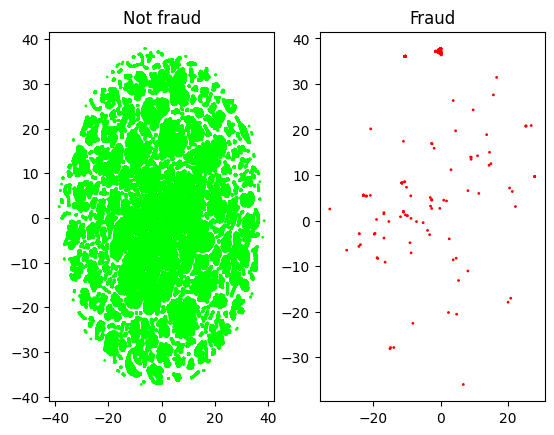

<Figure size 640x480 with 0 Axes>

In [29]:
with_fraud = embedded_credit_card_pca[credidcard_fraud_df[credidcard_fraud_df['Class']  == 1].index.values.tolist()]
not_fraud = embedded_credit_card_pca[credidcard_fraud_df[credidcard_fraud_df['Class']  == 0].index.values.tolist()]

plt.subplot(1, 2, 1)
plt.title('Not fraud')
plt.scatter(x=not_fraud[:, 0], y=not_fraud[:,1], s=1.0, c=np.vectorize(lambda _: '#00ff00')(not_fraud[:, 0]))

plt.subplot(1, 2, 2)
plt.title('Fraud')
plt.scatter(x=with_fraud[:, 0], y=with_fraud[:,1], s=1.0, c=np.vectorize(lambda _: '#ff0000')(with_fraud[:, 0]))
plt.show()
plt.clf()

## Feature Engenering


In [ ]:
# Create a new feild called 
credidcard_fraud_df["Time-Hour"]=credidcard_fraud_df["Time"]//60//60%24

# Plot dist of transactions based on hour
fig , axs = plt.subplots(1,2 , figsize = (8,8))

axs[0].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==0]['Time-Hour'].values , color = '#00ff00', bins=24)
axs[0].set_title('Not Fraud')
axs[0].set_xlabel('time of day')

axs[1].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==1]['Time-Hour'].values , color = '#ff0000', bins=24)
axs[1].set_title('Fraud')
axs[1].set_xlabel('time of day')


In [32]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')
# TODO: Remove ? or disable

# For each feature plot the data with the fitting curve

for i , f_id in enumerate(credidcard_fraud_df.columns ):
    if i>1: pass
    # ToDo add p-value to title
    plot_data_w_dist(credidcard_fraud_df[f_id], find_a_fitting_dist(credidcard_fraud_df[f_id]), f_id, n_bins=100)


NameError: name 'plot_data_w_dist' is not defined

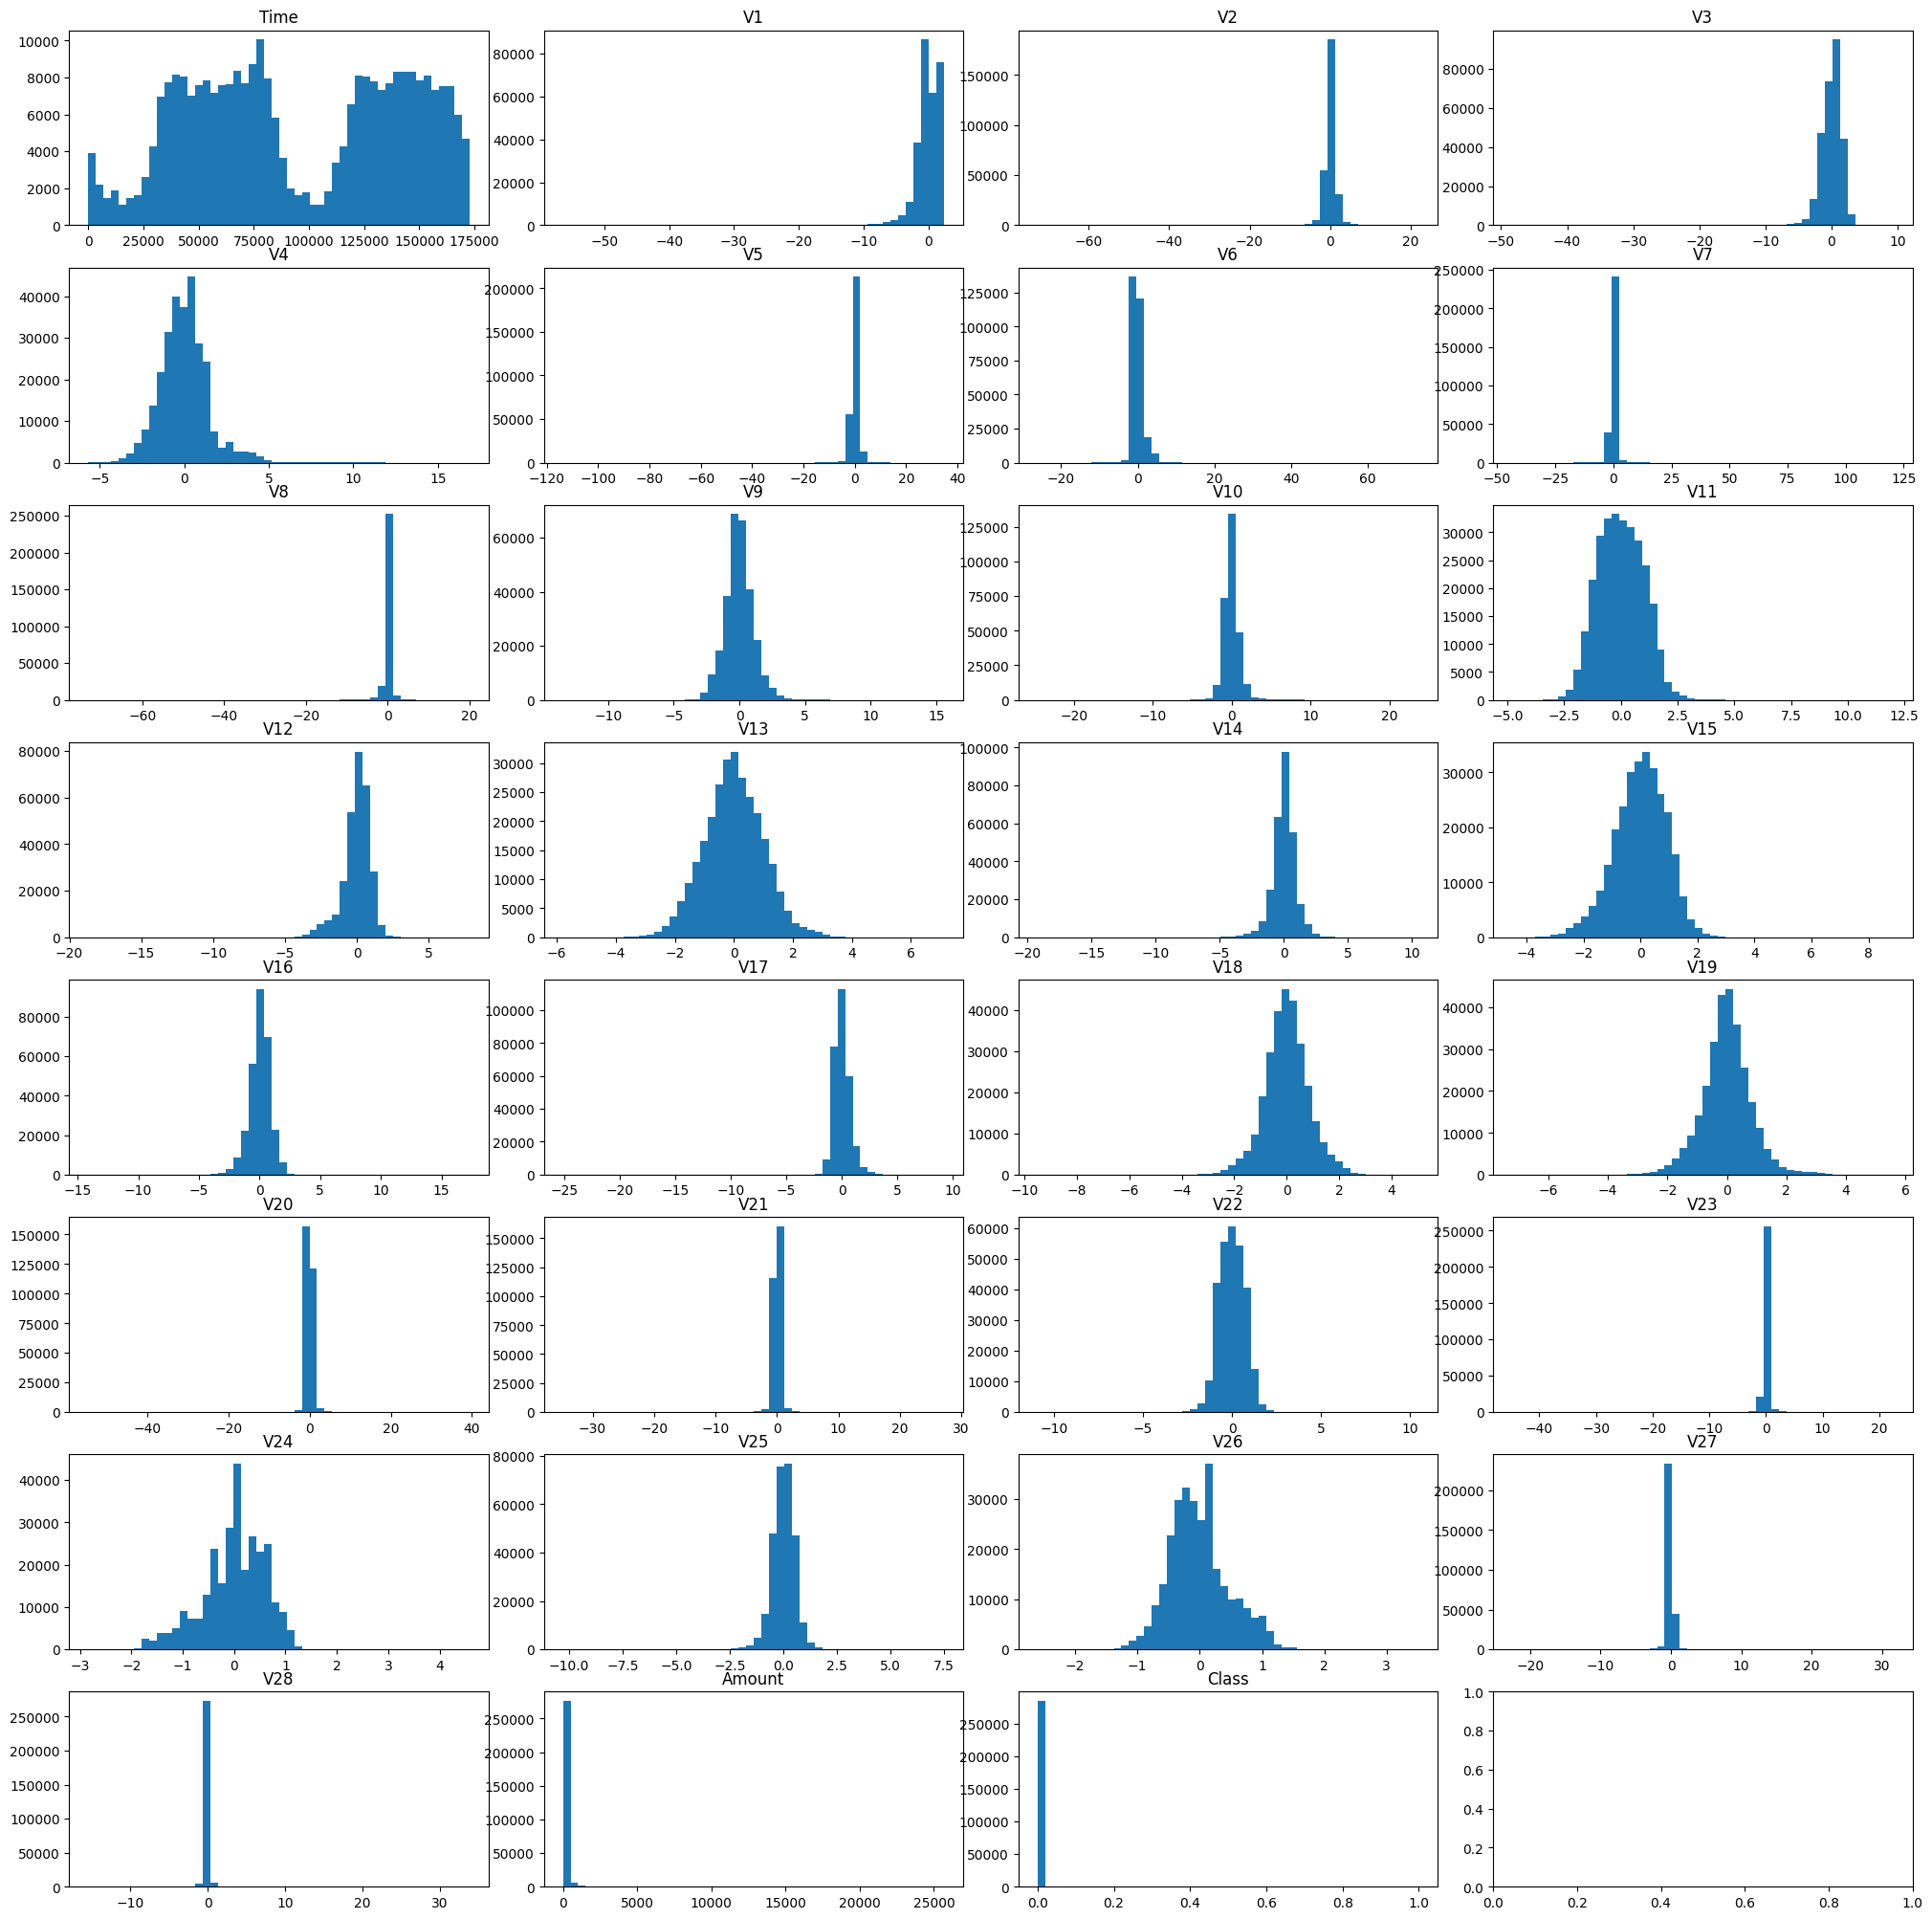

In [48]:
# plot distribution of all features

fig, axs = plt.subplots(16, 4, figsize=(20, 20))
fig.tight_layout()
for i , f_id in enumerate(credidcard_fraud_df.columns ):
    # axs[(2*i)//4][(2*i)%4].hist(credidcard_fraud_df[f_id], bins=50)
    # axs[i//4][i%4].set_title(f_id)

    axs[(2*i)//4][(2*i)%4].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==0][f_id].values , color = '#00ff00', bins=50)
    axs[(2*i)//4][(2*i)%4].set_title(f_id+' - Not Fraud')


    axs[(2*i+1)//4][(2*i+1)%4].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==1][f_id].values , color = '#ff0000', bins=15)
    axs[(2*i+1)//4][(2*i+1)%4].set_title(f_id+' - Fraud')

## Check for correlation between PCA features

FileNotFoundError: [Errno 2] No such file or directory: '.\\VPlots\\V1_V2.png'

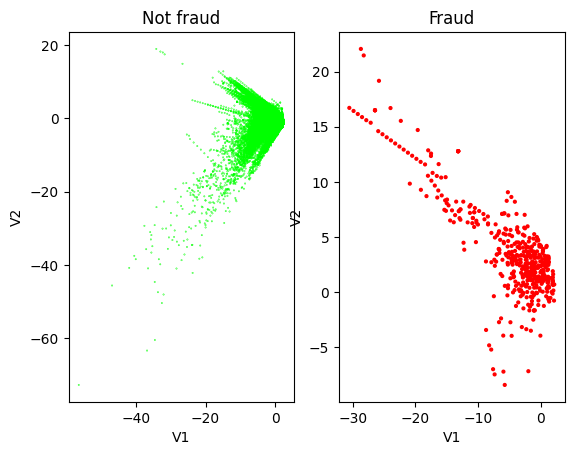

In [8]:
from itertools import combinations

# Plot combination of two features

columns = pd.Series(credidcard_fraud_df.columns)
v_columns = columns[columns.str.startswith('V')]

correlation_res = []

for col_i, col_j in combinations(v_columns, 2):
    correlation_res.append((col_i, col_j, credidcard_fraud_df[col_i].corr(credidcard_fraud_df[col_j])))

    no_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 0]
    plt.subplot(1, 2, 1)
    plt.title('Not fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=no_fraud[col_i], y=no_fraud[col_j], s=1.0, c=no_fraud['Class'].map(lambda _: "#00ff00"))

    with_fraud = credidcard_fraud_df[credidcard_fraud_df['Class'] == 1]
    plt.subplot(1, 2, 2)
    plt.title('Fraud')
    plt.xlabel(col_i)
    plt.ylabel(col_j)
    plt.scatter(x=with_fraud[col_i], y=with_fraud[col_j], s=1.0, c=with_fraud['Class'].map(lambda _: "#ff0000"))
    plt.savefig(f".\\Vi_vj_plots\\{col_i}_{col_j}.png")
    plt.clf()

correlation_res.sort(key=lambda x: x[2], reverse=True)
print('\n'.join(map(lambda x: f'{x[0]}:{x[1]} - {x[2]}', correlation_res)))

## Feature Engenering


Text(0.5, 0, 'time of day')

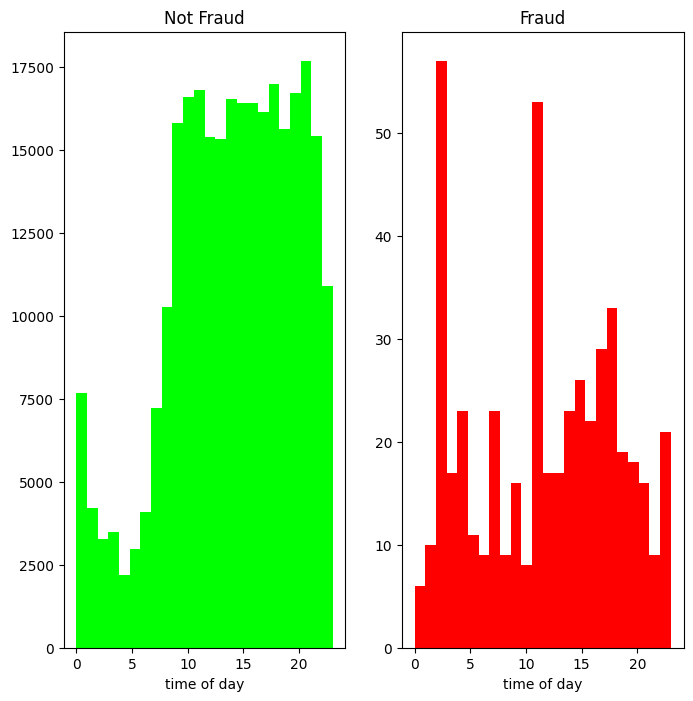

In [49]:
# Create a new feild called 
credidcard_fraud_df["Time-Hour"]=credidcard_fraud_df["Time"]//60//60%24

# Plot dist of transactions based on hour
fig , axs = plt.subplots(1,2 , figsize = (8,8))

axs[0].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==0]['Time-Hour'].values , color = '#00ff00', bins=24)
axs[0].set_title('Not Fraud')
axs[0].set_xlabel('time of day')

axs[1].hist(credidcard_fraud_df[credidcard_fraud_df['Class']==1]['Time-Hour'].values , color = '#ff0000', bins=24)
axs[1].set_title('Fraud')
axs[1].set_xlabel('time of day')


### Clean and wrangle

### Do some useful stuff